## Import Required Libraries

In [1]:
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam
from joblib import dump
import numpy as np
import matplotlib.pyplot as plt
import pickle
from flask import Flask, request, jsonify
import requests

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


2023-04-24 00:23:04.292541: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
model = Sequential([
    Conv2D(16, (3, 3), activation="relu", input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation="relu"),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D(2, 2)
    ])
model.add(Flatten())
model.add(Dense(100, activation="relu"))
model.add(Dense(80, activation="softmax"))



model.summary()


2023-04-24 00:23:41.049095: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-04-24 00:23:41.049577: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-24 00:23:41.049594: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-24 00:23:41.106936: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (charles): /proc/driver/nvidia/version does not exist
2023-04-24 00:23:41.122781: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlo

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 43264)             0

## Define training parameters and callbacks

In [3]:
adam = Adam(learning_rate=0.001)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'], run_eagerly=True)
bs = 100
train_dir = "../images/train/"
test_dir = "../images/test/"
train_datagen = ImageDataGenerator(rescale=1.0/255.)
test_datagen = ImageDataGenerator(rescale=1.0/255.)
train_generator = train_datagen.flow_from_directory(train_dir, batch_size=bs, class_mode='categorical', target_size=(224, 224), shuffle=True)
validation_generator = test_datagen.flow_from_directory(test_dir, batch_size=bs, class_mode='categorical', target_size=(224, 224), shuffle=True)




Found 22566 images belonging to 80 classes.
Found 6505 images belonging to 80 classes.


## Fit Model

In [4]:
history = model.fit(train_generator,
                              steps_per_epoch=train_generator.samples // bs,
                              epochs=10,
                              validation_data=validation_generator,
                              validation_steps=validation_generator.samples // bs)

2023-04-24 00:23:48.857623: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 60211200 exceeds 10% of free system memory.
2023-04-24 00:23:48.997429: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-04-24 00:23:49.011256: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2400000000 Hz


Epoch 1/10


2023-04-24 00:23:53.639637: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 60211200 exceeds 10% of free system memory.
2023-04-24 00:23:53.711609: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 315417600 exceeds 10% of free system memory.
2023-04-24 00:23:54.483618: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 315417600 exceeds 10% of free system memory.
2023-04-24 00:23:54.729187: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 315417600 exceeds 10% of free system memory.


225/225 [==============================] - 1790s 8s/step - loss: 3.8718 - accuracy: 0.1181 - val_loss: 3.8403 - val_accuracy: 0.1337
Epoch 2/10
225/225 [==============================] - 1754s 8s/step - loss: 3.3531 - accuracy: 0.1983 - val_loss: 3.6740 - val_accuracy: 0.1512
Epoch 3/10
225/225 [==============================] - 1695s 8s/step - loss: 2.9807 - accuracy: 0.2642 - val_loss: 3.5746 - val_accuracy: 0.1792
Epoch 4/10
225/225 [==============================] - 1689s 7s/step - loss: 2.5564 - accuracy: 0.3447 - val_loss: 3.6540 - val_accuracy: 0.1769
Epoch 5/10
225/225 [==============================] - 1563s 7s/step - loss: 1.9208 - accuracy: 0.4918 - val_loss: 3.9137 - val_accuracy: 0.1877
Epoch 6/10
225/225 [==============================] - 1695s 8s/step - loss: 1.2762 - accuracy: 0.6495 - val_loss: 4.7286 - val_accuracy: 0.1675
Epoch 7/10
225/225 [==============================] - 1485s 7s/step - loss: 0.7425 - accuracy: 0.7960 - val_loss: 5.6971 - val_accuracy: 0.1620
Epo

## Save model

In [5]:
model.save('./Animals_prediction_model.h5')
weights = model.get_weights()
dump(weights, './Animals_prediction_model.joblib')
with open('./Animals_prediction_model.pkl', 'wb') as f:
    pickle.dump(weights, f)

## Evaluate the model

66/66 [==============================] - 237s 4s/step - loss: 7.6345 - accuracy: 0.1499
Test loss: 7.634481906890869
Test accuracy: 0.14988470077514648


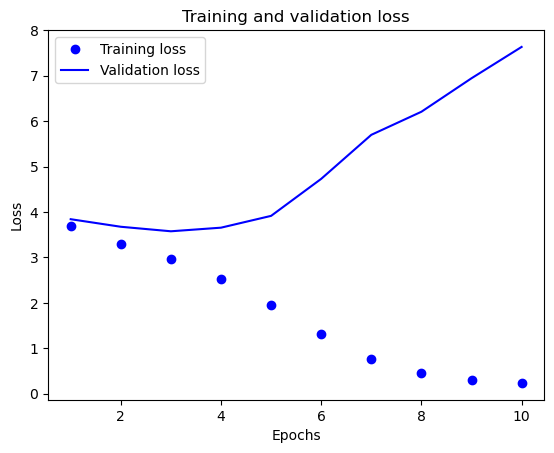

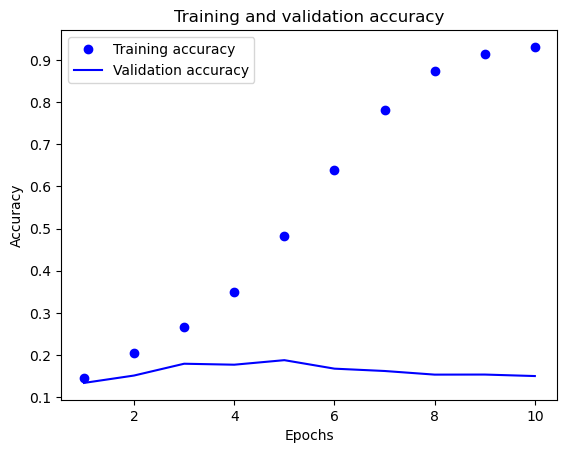

In [6]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(validation_generator)

# Print the test loss and accuracy
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy over epochs
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Test prediction

In [7]:
import requests

# Define the Flask application endpoint URL
url = "http://localhost:5050/predict"

# Load the image file as bytes
with open("./predict/3.jpg", "rb") as image_file:
    image_data = image_file.read()

# Send a POST request to the Flask application with the image file
response = requests.post(url, files={"file": image_data})

# Parse the response to get the predicted animal category
if response.status_code == 200:
    result = response.json()
    prediction = result["prediction"]
    print(f"The predicted animal category is: {prediction}")
else:
    print("Error: Failed to get prediction from Flask application.")

FileNotFoundError: [Errno 2] No such file or directory: './predict/3.jpg'